In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np

from Utilities.utils import (
    analyze_graph_dataset,
    build_graph_list,
    convert_nx_to_pyg,
    convert_nx_to_pyg_2,
    generate_new_fully_connected_graph,
    visualize_graph,
)

from Utilities.model import (
    GraphGenerator,
    train_model,
    classify_edges
)

In [2]:
# --- Data Loading ---
with open('Dataset\Graphs.JSON', 'r') as file:
    graph_data = json.load(file)

# --- Analyze and Filter Dataset ---
type_counts, type_encodings, graph_data = analyze_graph_dataset(graph_data)
type_reverse_encodings = {idx: name for name, idx in type_encodings.items()}

print("Node type counts:", type_counts)
print("Node type to index mapping:", type_encodings)
print("Filtered graph data:", graph_data)

Node type counts: defaultdict(<class 'int'>, {'Circulation': 94, 'Bed': 183, 'Living': 100, 'Bath': 104})
Node type to index mapping: {'Bed': 0, 'Bath': 1, 'Living': 2, 'Circulation': 3}
Filtered graph data: [{'Graph': {'Properties': {'NodeCount': 5, 'EdgeCount': 5, 'Type': None, 'FullyConnected': True, 'GGUID': 'cbdf578a-633a-43eb-8342-7c5e6c326f42'}, 'Attributes': {'Width': 8.029813545769926, 'Length': 8.312131408747348}, 'Nodes': [{'Properties': {'Id': 'N0', 'Type': 'Circulation', 'Point': {'X': 3.963, 'Y': 2.401, 'Z': 0.0}, 'Valence': 4, 'IsInGraph': True, 'GGUID': '291d9853-f8b0-43d0-80b7-9a4dd3e0f404', 'IsNaked': False, 'Angle': 'null'}, 'Attributes': {}, 'Point': {'X': 3.963, 'Y': 2.401, 'Z': 0.0}}, {'Properties': {'Id': 'N1', 'Type': 'Bed', 'Point': {'X': 1.5645, 'Y': 1.568, 'Z': 0.0}, 'Valence': 2, 'IsInGraph': True, 'GGUID': '22630c40-1283-484f-bf6a-e31037d258e5', 'IsNaked': False, 'Angle': 70.84786551326103}, 'Attributes': {}, 'Point': {'X': 1.5645, 'Y': 1.568, 'Z': 0.0}}, {

Graph count: 100
Visualizing graph #93


c:\Users\baoqt\OneDrive\Documents\GitHub\GenAIExample\Graph\Utilities\utils.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


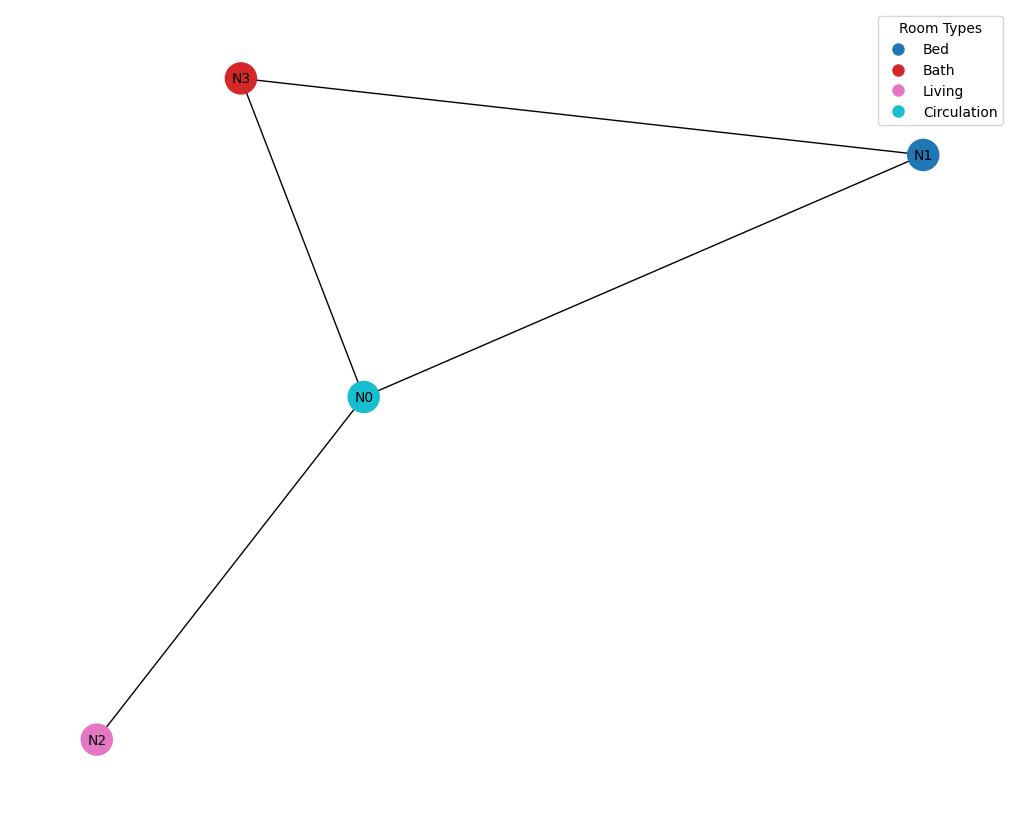

In [3]:
# --- Process Graphs (using reusable function) ---
graph_list = build_graph_list(graph_data, type_encodings)

print("Graph count:", len(graph_list))

# Visualize a random graph from the list
random_index = random.randint(0, len(graph_list) - 1)
print(f"Visualizing graph #{random_index}")
visualize_graph(graph_list[random_index], type_encodings)

In [4]:
# --- Convert to PyG Data ---
pyg_graphs = []
for i, graph in enumerate(graph_list):
    data_obj = convert_nx_to_pyg_2(graph, type_encodings)
    if data_obj is not None:
        pyg_graphs.append(data_obj)

print(f"Converted {len(pyg_graphs)} graphs to PyTorch Geometric Data objects.")

# Print the shape of an example tensor from the PyG graphs
if len(pyg_graphs) > 0:
    print("Example tensor shape:", pyg_graphs[0].x.shape)
else:
    print("No PyG graphs available.")

Converted 100 graphs to PyTorch Geometric Data objects.
Example tensor shape: torch.Size([5, 9])


In [5]:
# --- Model Setup ---
hidden_dim = 64
model = GraphGenerator(node_features=pyg_graphs[0].x.shape[1], hidden_dim=hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

print("Model summary:")
print(model)

Model summary:
GraphGenerator(
  (conv1): GATConv(9, 64, heads=1)
  (conv2): GATConv(64, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (node_predictor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=9, bias=True)
  )
  (edge_predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [14]:
# --- Training ---
num_epochs = 500
batch_size = 32
train_loader = DataLoader(pyg_graphs, batch_size=batch_size, shuffle=True)

train_model(model, train_loader, optimizer, criterion, num_epochs=100, device='cpu')

Epoch 1/100, Loss: 0.1844
Epoch 2/100, Loss: 0.2227
Epoch 3/100, Loss: 0.2110
Epoch 4/100, Loss: 0.2214
Epoch 5/100, Loss: 0.1772
Epoch 6/100, Loss: 0.2003
Epoch 7/100, Loss: 0.2247
Epoch 8/100, Loss: 0.1907
Epoch 9/100, Loss: 0.1718
Epoch 10/100, Loss: 0.2292
Epoch 11/100, Loss: 0.1881
Epoch 12/100, Loss: 0.2370
Epoch 13/100, Loss: 0.2742
Epoch 14/100, Loss: 0.2653
Epoch 15/100, Loss: 0.2433
Epoch 16/100, Loss: 0.2349
Epoch 17/100, Loss: 0.2268
Epoch 18/100, Loss: 0.2319
Epoch 19/100, Loss: 0.2649
Epoch 20/100, Loss: 0.2489
Epoch 21/100, Loss: 0.2019
Epoch 22/100, Loss: 0.1791
Epoch 23/100, Loss: 0.1721
Epoch 24/100, Loss: 0.2172
Epoch 25/100, Loss: 0.1846
Epoch 26/100, Loss: 0.1989
Epoch 27/100, Loss: 0.2188
Epoch 28/100, Loss: 0.1902
Epoch 29/100, Loss: 0.2161
Epoch 30/100, Loss: 0.1961
Epoch 31/100, Loss: 0.2200
Epoch 32/100, Loss: 0.1725
Epoch 33/100, Loss: 0.2431
Epoch 34/100, Loss: 0.1672
Epoch 35/100, Loss: 0.2033
Epoch 36/100, Loss: 0.2494
Epoch 37/100, Loss: 0.1556
Epoch 38/1

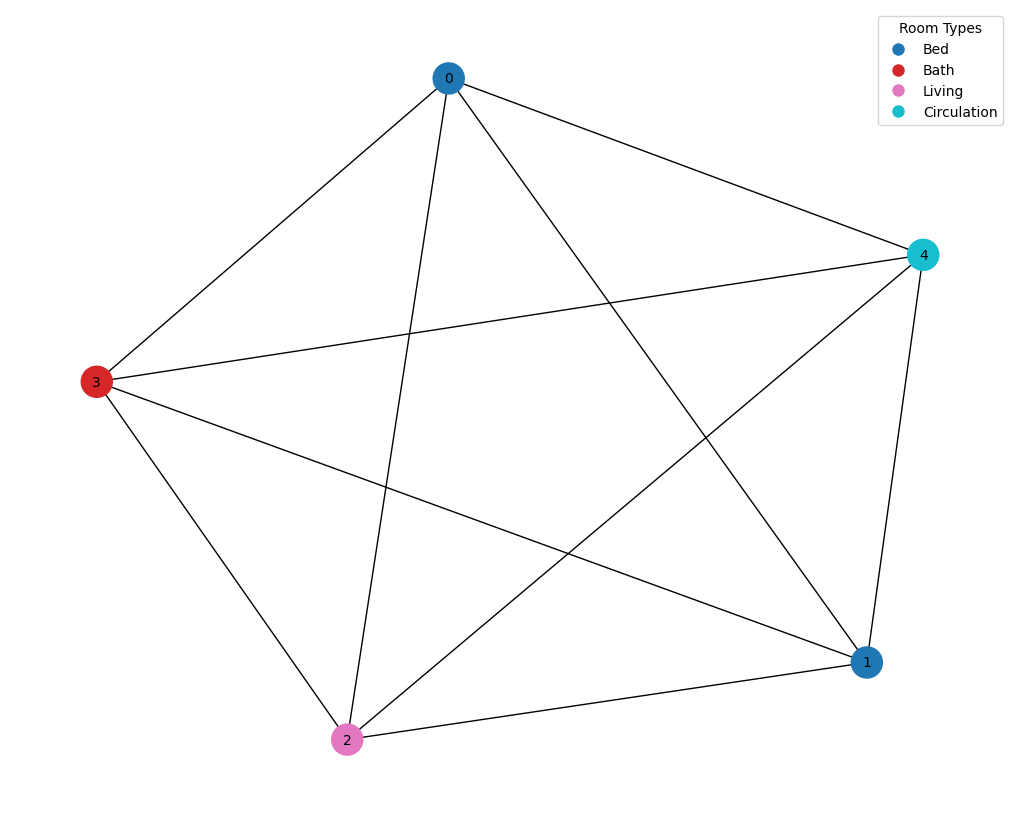

In [22]:
# --- Example: Generate and Visualize New Graph ---
required_nodes = {
    'Bed': 2,
    'Living': 1,
    'Bath': 1,
    'Circulation': 1
}
apartment_width = 5.0
apartment_length = 10.0
num_additional_nodes = 0

new_graph = generate_new_fully_connected_graph(
    required_nodes=required_nodes,
    apartment_width=apartment_width,
    apartment_length=apartment_length,
    num_additional_nodes=num_additional_nodes,
    type_encodings=type_encodings,
    type_reverse_encodings=type_reverse_encodings
)

visualize_graph(new_graph, type_encodings)

In [23]:
# Convert the new graph to a PyG graph
new_pyg_graph = convert_nx_to_pyg_2(new_graph, type_encodings)

# Print the result
if new_pyg_graph is not None:
    print("New PyG graph created successfully.")
    print(new_pyg_graph)
else:
    print("Failed to convert the new graph to PyG format.")

# Classify edges in the new PyG graph
if new_pyg_graph is not None:
    edge_classifications = classify_edges(model, new_pyg_graph, device='cpu')
    print("Edge classifications:", edge_classifications)
else:
    print("New PyG graph is not available for edge classification.")

New PyG graph created successfully.
Data(x=[5, 9], edge_index=[2, 20], area=[1], program_vector=[1, 4])
Edge classifications: (tensor([0.9144, 0.9144, 0.9144, 0.9144, 0.9144, 0.9144, 0.9144, 0.9144, 0.9144,
        0.9144, 0.9144, 0.9144, 0.9144, 0.9144, 0.9144, 0.9144, 0.9144, 0.9144,
        0.9144, 0.9144]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
